# Final project

### Author: Hang, Mahmud and Ben

In this Jupyter notebook, we simulate the climate change with a tiny increased temperature to verify our codes. We add 0.1 F here, and the results show pretty consistent with the origianl data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
import numpy as np # provide some mathematical functions
import xarray as xr # read, write, manipulate and analyze NetCDF files
from pathlib import Path # modify paths to files on the system
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
import pysumma as ps
import datetime

In [2]:
filemanager = '/home/jovyan/data/umpqua/settings/snow_fileManager_umpqua.txt'
executable = 'summa.exe'


In [3]:
# Stephan-Boltzmann constant (J/s/m^2/K^4)
STEFAN = 5.67e-8


def vapor_pressure(air_pressure, spec_humid):
    """See above for derivation"""
    return -1.607 * air_pressure * spec_humid / (spec_humid - 1)

def longwave_anderson(air_temp, vapor_pressure):
    """
    Referencce:
        Anderson, E.R., 1954. Energy budget studies, water loss
        investigations: lake Hefner studies. U.S. Geol. Surv. Prof. Pap. 269,
        71–119 [Available from U.S. Geological Survey, 807 National Center,
        Reston, VA 20192.].
    """
    emissivity = 0.68 + 0.036 * np.power(vapor_pressure/10, 0.5)
    return emissivity * np.power(air_temp, 4) * STEFAN

## The original case

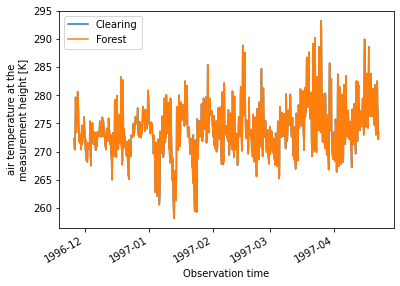

In [4]:
s = ps.Simulation(executable, filemanager)
s.run('local', run_suffix='baseline')

force_obs = s.force_file_list.open_forcing_data()[0]
force_obs['airtemp'].isel(hru=0).plot(label='Clearing')
force_obs['airtemp'].isel(hru=1).plot(label='Forest')
plt.legend()

In [5]:
force_obs['airtemp'].isel(hru=1).time

<xarray.DataArray 'time' (time: 1770)>
array(['1996-11-25T21:59:59.999996640', '1996-11-26T00:00:00.000000000',
       '1996-11-26T02:00:00.000003360', ..., '1997-04-22T03:59:59.999996640',
       '1997-04-22T06:00:00.000000000', '1997-04-22T08:00:00.000003360'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1996-11-25T21:59:59.999996640 ... 1997-04-...
Attributes:
    long_name:  Observation time

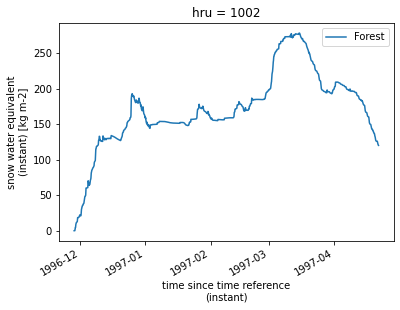

In [6]:

s.output['scalarSWE'].isel(hru=1).plot(label='Forest')
plt.legend()

## Add a constant temperature

In [7]:
### Add a constant temperature 
T_add = 0.1

In [8]:
s_temp = ps.Simulation(executable, filemanager)
force_file_obs = s_temp.force_file_list.options[0].name
force_obs = s_temp.force_file_list.open_forcing_data()[0]


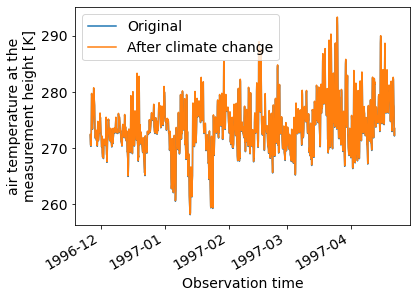

In [9]:
force_temp = force_obs.copy(deep=True)

plt.rcParams.update({'font.size': 14}) 
force_temp['airtemp'].isel(hru=1).plot(label='Original')

force_temp['airtemp'].loc[{'hru': 1}] += T_add

force_temp['airtemp'].isel(hru=1).plot(label='After climate change')
plt.legend()

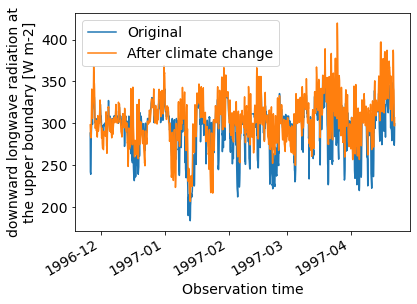

In [10]:
plt.rcParams.update({'font.size': 14}) 

## longwave radiation calculation from Anderson method
vp = vapor_pressure(force_temp['airpres'], force_temp['spechum'])
lw_anderson = longwave_anderson(force_temp['airtemp'], vp)
force_temp['LWRadAtm'].isel(hru=1).plot(label='Original')

force_temp['LWRadAtm'].values = lw_anderson.values # replace the longwave values
force_temp['LWRadAtm'].isel(hru=1).plot(label='After climate change')
plt.legend()

In [11]:
force_file_temp = force_file_obs.replace('9697', '9697_rescaled_temp')
force_temp.to_netcdf(force_file_temp, format='NETCDF3_CLASSIC')
s_temp.force_file_list.options[0].name = force_file_temp
new_force_file = str(s_temp.force_file_list.file_name).replace('.txt', '_rescaled_temp.txt')
s_temp.force_file_list.file_name = Path(new_force_file)
s_temp.force_file_list.write()

manager = ps.FileManager(s_temp.manager.original_path, s_temp.manager.file_name)
manager['forcingListFile'] = new_force_file.split('/')[-1]
manager.file_name = Path(str(s_temp.manager.file_name).replace('.txt', '_rescaled_temp.txt'))
manager.write()
new_filemanager = manager.original_path / manager.file_name

In [12]:
s_temp = ps.Simulation(executable, new_filemanager)
print(s_temp.force_file_list)
s_temp.run('local', run_suffix='rescaled_temp')

'Storck_AboveCanopyPP_9697_rescaled_temp.nc'


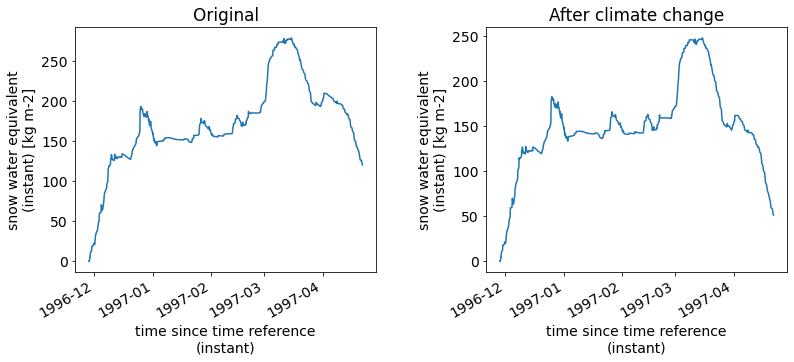

In [13]:
plt.figure(figsize = (12,6))
plt.rcParams.update({'font.size': 14}) 
plt.subplot(121)
s.output['scalarSWE'].isel(hru=1).plot(label='Original')
plt.title('Original')
plt.subplot(122)
s_temp.output['scalarSWE'].isel(hru=1).plot(label='After climate change')
plt.title('After climate change')
plt.tight_layout(pad=3.0)
#plt.legend()

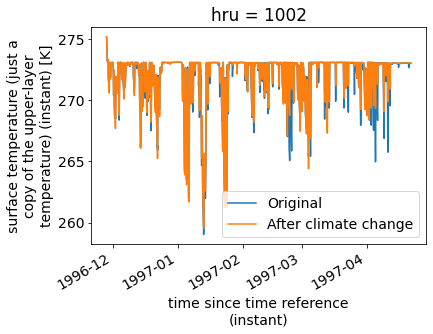

In [14]:
plt.rcParams.update({'font.size': 14}) 
s.output['scalarSurfaceTemp'].isel(hru=1).plot(label='Original')
s_temp.output['scalarSurfaceTemp'].isel(hru=1).plot(label='After climate change')
plt.legend()